# Продолжение
Основная идея данной части проекта - модификация полученной модели для расширенной классификации 

(добавили класс Other: текст не принадлежит ни одному из описанных в прошлой части проекта классов).


## Новое начало
Подключим необходимые библиотеки, обьявим необходимые функции и константы.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import plotly.graph_objects as go
import warnings
warnings.filterwarnings("ignore")
import sys, os
sys.path.append('/Users/nikitos_paravoz/Desktop/DL/NLPClassification/')
sys.path.append('/Users/nikitos_paravoz/Desktop/DL/NLPClassification/mylib/')
import mylib.ecommercedata as edata
import mylib.mymodel as mymodel
from mylib.ecommercedata import text_preprocess
import torch
import torch.nn as nn
from torch.utils.data import DataLoader


In [2]:
DEVICE = mymodel.DEVICE
BATCH_SIZE = 32

## Новый класс, новые методы
Постараемся сравнить два подхода для моделирования нового класса: аналитический и практический

In [3]:
category_dict = {'Household': 0, 'Books': 1, 'Clothing & Accessories': 2, 'Electronics' : 3}
other_category_dict = {'Household' : 0, 'Books' : 1, 'Clothing & Accessories' : 2, 'Electronics' : 3, 'Other' : 4}
data, _ = edata.prepare_data('ecommerceDataset.csv', category_dict)
save_y = data['category']
_, save_test_indices = edata.train_test_indices(data)
newdata, seq_len = edata.prepare_data('otherDatasetDesc.csv', other_category_dict)
train_indices, test_indices = edata.train_test_indices(newdata)

In [10]:
def show_data_balance(data, category_dict, text_title):
    val = []
    lab = []
    for k, v in category_dict.items():
        val.append(len(data[data['category'] == v]))
        lab.append(k)
    fig = go.Figure(data = [go.Pie(values = val, labels = lab, hole = 0.5, textinfo = 'percent', title = " ")])
    fig.update_layout(height = 500, width = 800, showlegend = True, title = dict(text = text_title, x = 0.5, y = 0.95)) 
    fig.show()
    return val
val_for_weight = show_data_balance(newdata, other_category_dict, "Unbalanced data")

### Практический подход:
Постараемся научить нашу модель распознавать текст на 5 классов, отдавая возможность распределять веса для этого самой по себе.

- 1. Обучаем с нуля (с предобученными векторами)


Следующие два пункта используют subword-вектора для лучшей работы с OOV:
- 2. Transfer learning модели из предыдущего пункта (fc слой only)
- 3. Дообучение модели из предыдущего пункта

Новый класс - описание товаров из иных классов.

#### 1:

In [5]:
X = newdata['description']
y = newdata['category']
vocabulary, vocabulary_to_int = edata.build_vocab(X)
X_tok = edata.huge_tokenize(X, vocabulary_to_int).to(int)

In [6]:
import gensim
modelfsttxt = gensim.models.KeyedVectors.load_word2vec_format('crawl-300d-2M.vec')
embedding_dict = modelfsttxt.key_to_index

In [7]:
VOCAB_SIZE = len(vocabulary) + 1
EMBEDDING_DIM = 300
HIDDEN_DIM = 100
NUM_CLASSES = 5
LSTM_LAYERS = 1
IS_BIDIRECTIONAL = True
LR = 1e-4

In [9]:
def prepare_matrix(embedding_dict):
    embedding_matrix = np.zeros((VOCAB_SIZE, EMBEDDING_DIM))
    for word, token in vocabulary:
        if word in embedding_dict:
            embedding_vector = modelfsttxt[word]
            embedding_matrix[token] = embedding_vector
    return embedding_matrix

In [15]:
prtrmodel = mymodel.LSTM_Classifier(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM, NUM_CLASSES, LSTM_LAYERS, IS_BIDIRECTIONAL)
prtrmodel.to(DEVICE)
prtr_embedding_matrix = prepare_matrix(embedding_dict)
prtrmodel.embedding.weight.data.copy_(torch.from_numpy(prtr_embedding_matrix))
prtrmodel.embedding.weight.data.requires_grad = False
weights = torch.Tensor([sum(val_for_weight)/val for val in val_for_weight]).to(DEVICE)
criterion = nn.NLLLoss(weight=weights)
prtroptimizer = torch.optim.Adam(prtrmodel.parameters(), lr=LR)

Создадим датасеты для расширенной класификации, а также сохраним тестовую выборку из предыдущего пункта, для проверки того, что модель не нарушила своей изначальной идеи - классификации товаров на 4 категории.

In [13]:
X_train = [X_tok[idx] for idx in train_indices]
y_train = [y[idx] for idx in train_indices]
X_test = [X_tok[idx] for idx in test_indices]
y_test = [y[idx] for idx in test_indices]
save_X_test = [X_tok[idx] for idx in save_test_indices]
save_y_test = [save_y[idx] for idx in save_test_indices]
train_dataset = edata.EcommerceDataset(X_train, y_train)
test_dataset = edata.EcommerceDataset(X_test, y_test)
save_test_dataset = edata.EcommerceDataset(save_X_test, save_y_test)
trainval_size = len(train_dataset)
val_size = int(trainval_size * 0.15)
train_size = trainval_size - val_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SIZE, drop_last=True)
valid_loader = DataLoader(val_dataset, shuffle=False, batch_size=BATCH_SIZE, drop_last=True)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=BATCH_SIZE, drop_last=True)
save_test_loader = DataLoader(save_test_dataset, shuffle=False, batch_size=BATCH_SIZE, drop_last=True)

In [16]:
prtrmodel = mymodel.train(prtrmodel, train_loader, valid_loader, DEVICE, criterion, prtroptimizer, 10)

Epoch 1/10 finished: train_accuracy = 80.94%, train_loss = 0.5973139941692353
Validation accuracy increased (0.00 --> 80.94).  Saving model ...
Epoch 2/10 finished: train_accuracy = 87.02%, train_loss = 0.44657245243971166
Validation accuracy increased (80.94 --> 87.02).  Saving model ...
Epoch 3/10 finished: train_accuracy = 89.76%, train_loss = 0.34322676807641983
Validation accuracy increased (87.02 --> 89.76).  Saving model ...
Epoch 4/10 finished: train_accuracy = 91.18%, train_loss = 0.30843901582635364
Validation accuracy increased (89.76 --> 91.18).  Saving model ...
Epoch 5/10 finished: train_accuracy = 90.19%, train_loss = 0.3070126875088765
Validation accuracy did not increase
Epoch 6/10 finished: train_accuracy = 92.0%, train_loss = 0.27398524910498123
Validation accuracy increased (91.18 --> 92.00).  Saving model ...
Epoch 7/10 finished: train_accuracy = 92.64%, train_loss = 0.27677910825094354
Validation accuracy increased (92.00 --> 92.64).  Saving model ...
Epoch 8/10 f

In [17]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report
def make_some_metrics(test_accuracy, test_loss, y_true, y_pred, category_list, modelname):
    print(f'Testing finished for {modelname}: Accuracy =  {test_accuracy}%, Loss = {test_loss} \nClassification report:\n', classification_report(y_true, y_pred, target_names=category_list, digits=4))
    cm = confusion_matrix(y_true, y_pred)
    cm_display = ConfusionMatrixDisplay(cm, display_labels=category_list)
    cm_display.plot(cmap="BuPu", xticks_rotation=45)

Протестируем модель на новом датасете:

Testing finished for model on new dataset: Accuracy =  92.7%, Loss = 0.2894456154654025 
Classification report:
                         precision    recall  f1-score   support

             Household     0.9135    0.9424    0.9277      1927
                 Books     0.9067    0.9153    0.9110      1051
Clothing & Accessories     0.9525    0.9552    0.9538      1049
           Electronics     0.9213    0.8452    0.8816      1053
                 Other     0.9413    0.9478    0.9445      1896

              accuracy                         0.9270      6976
             macro avg     0.9271    0.9212    0.9237      6976
          weighted avg     0.9271    0.9270    0.9267      6976



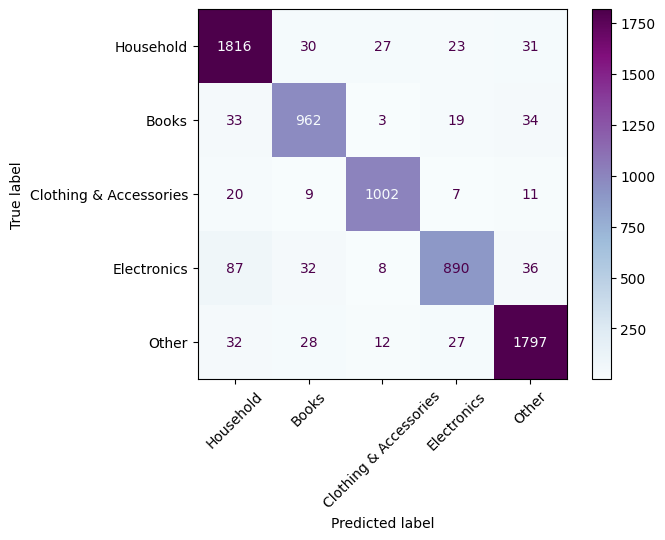

In [18]:
test_accuracy, test_loss, y_pred_list, y_test_list = mymodel.test(prtrmodel, DEVICE, test_loader, criterion)
make_some_metrics(test_accuracy, test_loss, y_pred_list, y_test_list, ['Household', 'Books', 'Clothing & Accessories', 'Electronics', 'Other'], 'model on new dataset')

Протестируем модель на сохранненой выборке:

Testing finished for model on saved dataset: Accuracy =  91.63%, Loss = 0.6538338394291838 
Classification report:
                         precision    recall  f1-score   support

             Household     0.9477    0.9892    0.9680      1941
                 Books     0.8936    0.9516    0.9217      1033
Clothing & Accessories     0.9301    0.9310    0.9305      1043
           Electronics     0.8625    0.8643    0.8634       980
                 Other     0.0000    0.0000    0.0000       155

              accuracy                         0.9163      5152
             macro avg     0.7268    0.7472    0.7367      5152
          weighted avg     0.8886    0.9163    0.9021      5152



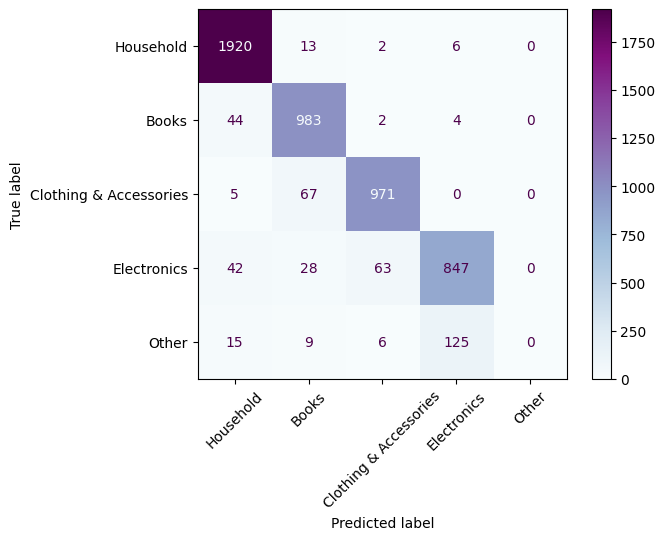

In [19]:
save_test_accuracy, save_test_loss, save_y_pred_list, save_y_test_list = mymodel.test(prtrmodel, DEVICE, save_test_loader, criterion)
make_some_metrics(save_test_accuracy, save_test_loss, save_y_pred_list, save_y_test_list, ['Household', 'Books', 'Clothing & Accessories', 'Electronics', 'Other'], 'model on saved dataset')

#### 2:

In [20]:
import fasttext
fsttxt = fasttext.load_model('crawl-300d-2M-subword.bin')
embedding_matrix = np.zeros((VOCAB_SIZE, EMBEDDING_DIM))
for word, token in vocabulary_to_int.items():
    embedding_vector = fsttxt[word]
    embedding_matrix[token] = embedding_vector

In [29]:
def create_frozen_model(grad=False):
    model = mymodel.LSTM_Classifier(48806, 300, 100, 4, 1, True)
    model.load_state_dict(torch.load('subw_model.pt'))
    model.to(DEVICE)
    model.embedding = nn.Embedding(VOCAB_SIZE, 300, padding_idx=0)
    model.fc = nn.Linear(200, NUM_CLASSES)
    model.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
    for i, layer in enumerate(model.children()):
        if i < len(list(model.children())) - 2:
            for param in layer.parameters():
                param.requires_grad = grad
    model.embedding.weight.requires_grad = False
    return model

In [23]:
prevmodel = create_frozen_model().to(DEVICE)
prevoptimizer = torch.optim.Adam(prevmodel.parameters(), lr=LR)

In [26]:
prevmodel = mymodel.train(prevmodel, train_loader, valid_loader, DEVICE, criterion, prevoptimizer, 10)

Epoch 1/10 finished: train_accuracy = 83.56%, train_loss = 0.44768416308439696
Validation accuracy increased (0.00 --> 83.56).  Saving model ...
Epoch 2/10 finished: train_accuracy = 83.68%, train_loss = 0.4468197958973738
Validation accuracy increased (83.56 --> 83.68).  Saving model ...
Epoch 3/10 finished: train_accuracy = 83.61%, train_loss = 0.445926763690435
Validation accuracy did not increase
Epoch 4/10 finished: train_accuracy = 83.68%, train_loss = 0.44513128801034046
Validation accuracy increased (83.68 --> 83.68).  Saving model ...
Epoch 5/10 finished: train_accuracy = 83.68%, train_loss = 0.4443219935664764
Validation accuracy increased (83.68 --> 83.68).  Saving model ...
Epoch 6/10 finished: train_accuracy = 83.68%, train_loss = 0.44366840158517545
Validation accuracy increased (83.68 --> 83.68).  Saving model ...
Epoch 7/10 finished: train_accuracy = 83.77%, train_loss = 0.44277664847098863
Validation accuracy increased (83.68 --> 83.77).  Saving model ...
Epoch 8/10 fi

Testing finished for model on new dataset: Accuracy =  84.0%, Loss = 0.4346256377090008 
Classification report:
                         precision    recall  f1-score   support

             Household     0.8043    0.8834    0.8420      1810
                 Books     0.8869    0.8516    0.8689      1105
Clothing & Accessories     0.9468    0.9248    0.9357      1077
           Electronics     0.8530    0.8340    0.8434       988
                 Other     0.7858    0.7515    0.7682      1996

              accuracy                         0.8400      6976
             macro avg     0.8553    0.8491    0.8516      6976
          weighted avg     0.8410    0.8400    0.8398      6976



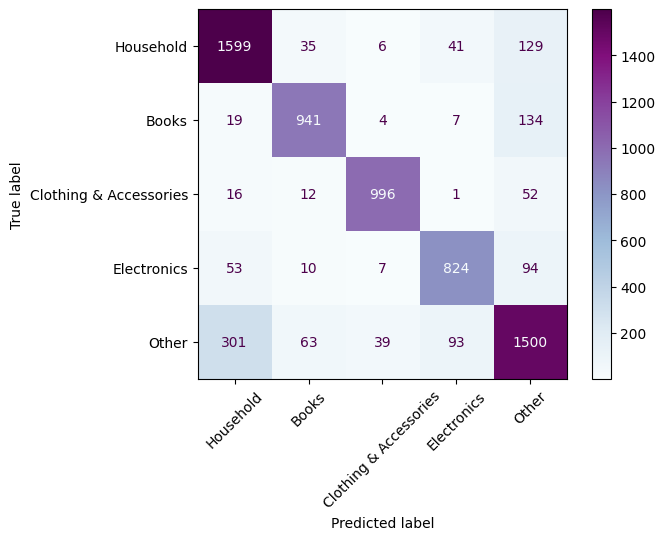

In [27]:
test_accuracy, test_loss, y_pred_list, y_test_list = mymodel.test(prevmodel, DEVICE, test_loader, criterion)
make_some_metrics(test_accuracy, test_loss, y_pred_list, y_test_list, ['Household', 'Books', 'Clothing & Accessories', 'Electronics', 'Other'], 'model on new dataset')

Testing finished for model on saved dataset: Accuracy =  82.69%, Loss = 0.6099268964358738 
Classification report:
                         precision    recall  f1-score   support

             Household     0.7902    0.9496    0.8626      1686
                 Books     0.8436    0.9412    0.8897       986
Clothing & Accessories     0.9042    0.9086    0.9064      1039
           Electronics     0.8014    0.8648    0.8319       910
                 Other     0.0000    0.0000    0.0000       531

              accuracy                         0.8269      5152
             macro avg     0.6679    0.7328    0.6981      5152
          weighted avg     0.7440    0.8269    0.7823      5152



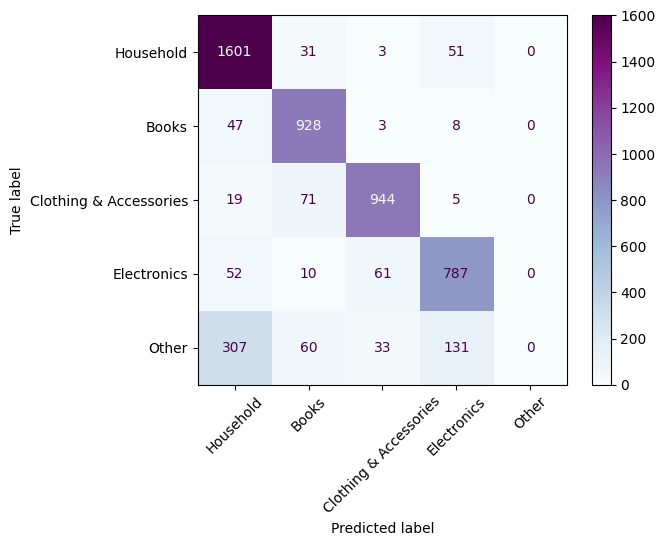

In [28]:
save_test_accuracy, save_test_loss, save_y_pred_list, save_y_test_list = mymodel.test(prevmodel, DEVICE, save_test_loader, criterion)
make_some_metrics(save_test_accuracy, save_test_loss, save_y_pred_list, save_y_test_list, ['Household', 'Books', 'Clothing & Accessories', 'Electronics', 'Other'], 'model on saved dataset')

Результаты обучения лишь последнего слоя оставляют желать лучшего, но это достаточно просто обьяснить, мы переобучали лишь 1 последний Linear слой, в то время как основной LSTM слой заморожен, выход LSTM слоя содержит ключевую информацию для классификации на 4 категории, Linear слой же пытается линейным отображением перевести это на 5 категорий, но в тексте между other и 4 другими категориями не факт, что существует такое отображение (как видим из результатов - не существует, как минимум в нашем датасете точно)

#### 3:

In [34]:
retrmodel = create_frozen_model(True).to(DEVICE)
retroptimizer = torch.optim.Adam(retrmodel.parameters(), lr=LR)

In [38]:
retrmodel = mymodel.train(retrmodel, train_loader, valid_loader, DEVICE, criterion, retroptimizer)

Epoch 1/6 finished: train_accuracy = 91.25%, train_loss = 0.2953321418223473
Validation accuracy increased (0.00 --> 91.25).  Saving model ...
Epoch 2/6 finished: train_accuracy = 91.03%, train_loss = 0.2996602207708817
Validation accuracy did not increase
Epoch 3/6 finished: train_accuracy = 91.42%, train_loss = 0.2897212885893308
Validation accuracy increased (91.25 --> 91.42).  Saving model ...
Epoch 4/6 finished: train_accuracy = 91.63%, train_loss = 0.2789038618883261
Validation accuracy increased (91.42 --> 91.63).  Saving model ...
Epoch 5/6 finished: train_accuracy = 91.03%, train_loss = 0.2879273764789104
Validation accuracy did not increase
Epoch 6/6 finished: train_accuracy = 91.85%, train_loss = 0.287113480671094
Validation accuracy increased (91.63 --> 91.85).  Saving model ...


Testing finished for model on new dataset: Accuracy =  91.74%, Loss = 0.28578320461744017 
Classification report:
                         precision    recall  f1-score   support

             Household     0.8974    0.9130    0.9051      1954
                 Books     0.8992    0.9316    0.9151      1024
Clothing & Accessories     0.9420    0.9501    0.9461      1043
           Electronics     0.8861    0.8708    0.8784       983
                 Other     0.9508    0.9204    0.9353      1972

              accuracy                         0.9174      6976
             macro avg     0.9151    0.9172    0.9160      6976
          weighted avg     0.9178    0.9174    0.9175      6976



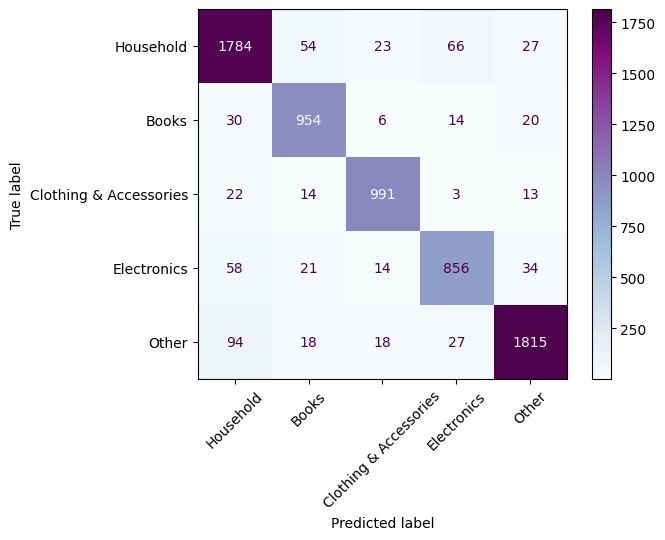

In [39]:
test_accuracy, test_loss, y_pred_list, y_test_list = mymodel.test(retrmodel, DEVICE, test_loader, criterion)
make_some_metrics(test_accuracy, test_loss, y_pred_list, y_test_list, ['Household', 'Books', 'Clothing & Accessories', 'Electronics', 'Other'], 'model on new dataset')

Testing finished for model on saved dataset: Accuracy =  86.67%, Loss = 0.5916929576800477 
Classification report:
                         precision    recall  f1-score   support

             Household     0.8840    0.9377    0.9101      1910
                 Books     0.8609    0.9275    0.8930      1021
Clothing & Accessories     0.9071    0.9115    0.9093      1039
           Electronics     0.7943    0.8423    0.8176       926
                 Other     0.0000    0.0000    0.0000       256

              accuracy                         0.8667      5152
             macro avg     0.6893    0.7238    0.7060      5152
          weighted avg     0.8240    0.8667    0.8447      5152



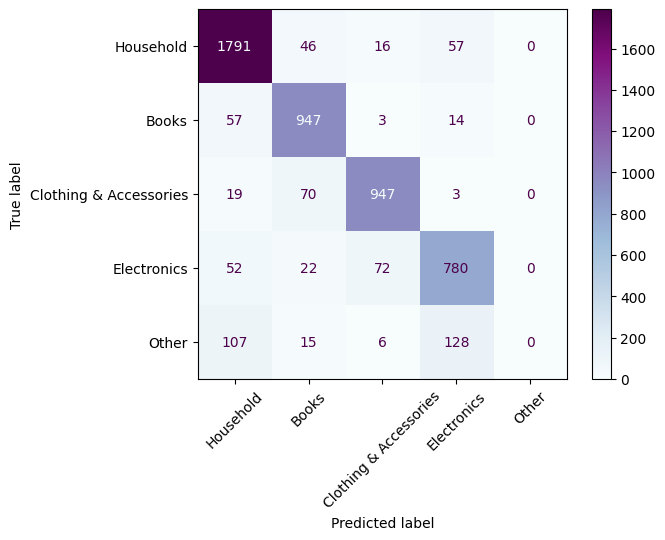

In [40]:
save_test_accuracy, save_test_loss, save_y_pred_list, save_y_test_list = mymodel.test(retrmodel, DEVICE, save_test_loader, criterion)
make_some_metrics(save_test_accuracy, save_test_loss, save_y_pred_list, save_y_test_list, ['Household', 'Books', 'Clothing & Accessories', 'Electronics', 'Other'], 'model on saved dataset')

### Итог практического подхода:
Как видно, модель с хорошей точностью определяет класс Other, при этом не теряя в точности предсказаний на предыдущие классы.
Результаты удовлетворительны, но стоит рассмотреть и аналитический подход, речь о котором пойдет ниже.

### Аналитический подход:

С помощью диаграммы размаха (boxplot, ящик с усами), найдем нижнюю границу уверенности в выбранном классе модели из предыдущего пункта. С помощью этой нижней границы создадим threshold метод для новой классификации.

In [41]:
prevX = data['description']
prevvocabulary, prevvocabulary_to_int = edata.build_vocab(prevX)
prev_X_tok = edata.huge_tokenize(prevX, prevvocabulary_to_int).to(int)
prev_X_test = [prev_X_tok[idx] for idx in save_test_indices]
prev_y_test = [save_y[idx] for idx in save_test_indices]

In [42]:
X_tok_new = edata.huge_tokenize(X, prevvocabulary_to_int).to(int)
X_test_new = [X_tok_new[idx] for idx in test_indices]
y_test_new = [y[idx] for idx in test_indices]

In [43]:
new_test_dataset =  edata.EcommerceDataset(X_test_new, y_test_new )
new_test_loader = DataLoader(new_test_dataset, shuffle=False, batch_size=BATCH_SIZE, drop_last=True)

In [44]:
prev_test_dataset = edata.EcommerceDataset(prev_X_test, prev_y_test)
prev_test_loader = DataLoader(prev_test_dataset, shuffle=False, batch_size=BATCH_SIZE, drop_last=True)

In [60]:
prevmodel = mymodel.LSTM_Classifier(len(prevvocabulary) + 1, 300, 100, 4, 1, True)
prevmodel.load_state_dict(torch.load('saved_model.pt'))
prevmodel.to(DEVICE)

LSTM_Classifier(
  (embedding): Embedding(48890, 300, padding_idx=0)
  (lstm): LSTM(300, 100, batch_first=True, bidirectional=True)
  (attention): Attention(
    (attn): Linear(in_features=400, out_features=200, bias=True)
    (v): Linear(in_features=200, out_features=1, bias=False)
  )
  (fc): Linear(in_features=200, out_features=4, bias=True)
  (softmax): LogSoftmax(dim=1)
)

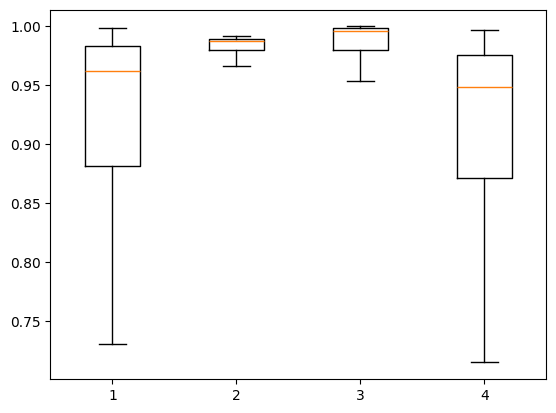

In [72]:
'''
category = ['Household', 'Books', 'Clothing & Accesories', 'Electronics']
rows_list = []
from tqdm import tqdm
with torch.no_grad():
    for x in tqdm(X_test):
        x, h = x.reshape(1, len(x)).to(DEVICE),  model.init_hidden(1)
        out, _, _ = model(x, h)
        pred = torch.argmax(out, dim=1).to(int)
        prob = torch.exp(out).to(torch.float32).squeeze()
        dictrow = {category[pred] : float(prob[pred])}
        rows_list.append(dictrow)
df = pd.DataFrame(rows_list, columns=category)
df_h = df['Household']
df_b = df['Books']
df_c = df['Clothing & Accesories']
df_e = df['Electronics']
...
plt.boxplot([df_h, df_b, df_c, df_e], 0, '')
...
'''
from IPython.display import Image
Image(filename='boxplotnew.png')

Как видно из диаграммы, пороговое значение t ~ 0.71 будет достаточно точно отделять исходные классы от добавленного.

In [73]:
def threshold_test(model, device, dataloader, loss_fn, t=0.72):
    losses  = []
    y_pred_list = []
    y_test_list = []
    correct = 0
    total = 0
    with torch.no_grad():
        model.eval()
        for x_batch, y_batch in dataloader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            h = model.init_hidden(y_batch.size(0))
            output, h, attn = model(x_batch, h)
            
            loss = loss_fn(output, y_batch)
            losses.append(loss.item())

            y_pred = torch.argmax(output, dim=1)
            
            y_check, _ = torch.max(torch.exp(output), dim=1)
            y_pred += 1
            mask = y_check > t
            y_pred *= mask
            y_pred -= 1
            
            y_pred = torch.Tensor(list(map(lambda x: 4 if x == -1 else x, y_pred))).to(int).to(DEVICE)
            
            correct += torch.sum(y_pred==y_batch).item()
            total += y_batch.size(0)
            y_pred_list.extend(y_pred.squeeze().tolist())
            y_test_list.extend(y_batch.squeeze().tolist())

    accuracy = round(100 * correct / total, 2)
    return accuracy, np.mean(losses), y_pred_list, y_test_list

Testing finished for previous model on previous dataset with threshold: Accuracy =  88.51%, Loss = 0.231394442758575 
Classification report:
                         precision    recall  f1-score   support

             Household     0.8727    0.9485    0.9090      1864
                 Books     0.8873    0.9799    0.9313       996
Clothing & Accessories     0.9492    0.9547    0.9520      1038
           Electronics     0.8401    0.9494    0.8914       869
                 Other     0.0000    0.0000    0.0000       385

              accuracy                         0.8851      5152
             macro avg     0.7099    0.7665    0.7367      5152
          weighted avg     0.8202    0.8851    0.8511      5152



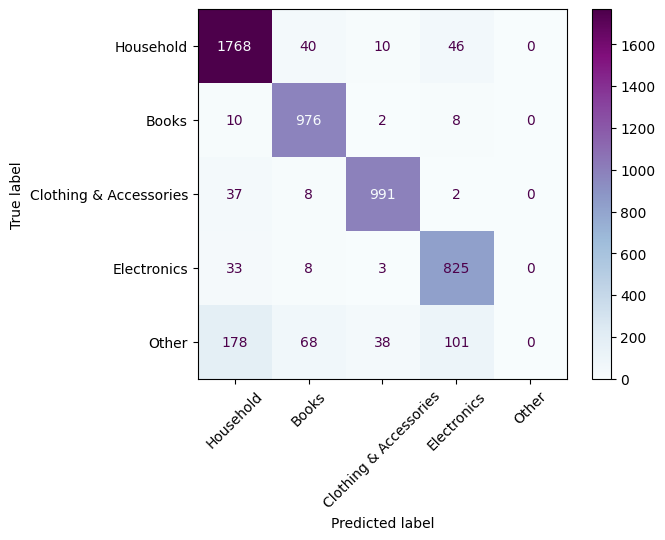

In [74]:
criterion = nn.NLLLoss()
prev_test_acc, prev_test_loss, prev_y_predl, prev_y_testl = threshold_test(prevmodel, DEVICE, prev_test_loader, criterion)
make_some_metrics(prev_test_acc, prev_test_loss, prev_y_predl, prev_y_testl, ['Household', 'Books', 'Clothing & Accessories', 'Electronics', 'Other'], 'previous model on previous dataset with threshold')

Testing finished for previous model on new dataset with threshold: Accuracy =  83.26%, Loss = 0.17802771911400994 
Classification report:
                         precision    recall  f1-score   support

             Household     0.8747    0.8043    0.8381      2162
                 Books     0.8869    0.8737    0.8803      1077
Clothing & Accessories     0.9430    0.9219    0.9323      1076
           Electronics     0.8344    0.8602    0.8471       937
                 Other     0.6967    0.7715    0.7322      1724

              accuracy                         0.8326      6976
             macro avg     0.8471    0.8463    0.8460      6976
          weighted avg     0.8377    0.8326    0.8342      6976



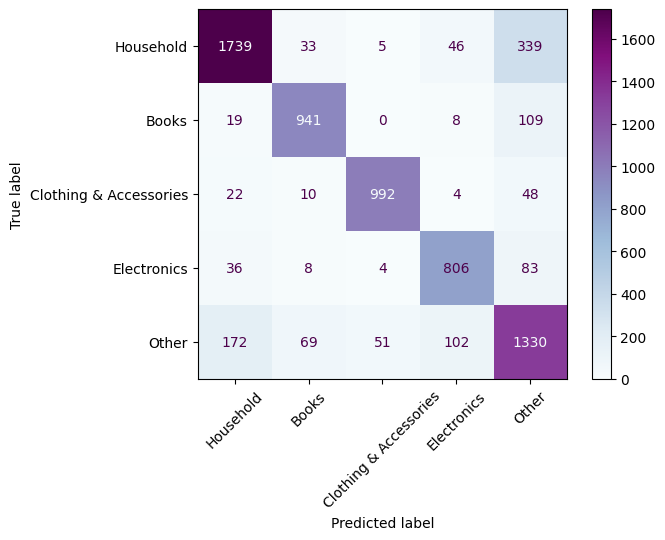

In [75]:
prev_test_acc, prev_test_loss, prev_y_predl, prev_y_testl = threshold_test(prevmodel, DEVICE, new_test_loader, criterion)
make_some_metrics(prev_test_acc, prev_test_loss, prev_y_predl, prev_y_testl, ['Household', 'Books', 'Clothing & Accessories', 'Electronics', 'Other'], 'previous model on new dataset with threshold')

### Итог аналитического подхода
Протестированное пороговое значение на расширенном датасете выдает результаты хуже, чем модель, обученная на определение 5-го класса. 